# Seismic SEG-Y files processing

## Introduction

This Python notebook is designed for anyone working with seismic data. It simplifies the process of handling SEG-Y files by extracting important metadata, analyzing the data, and creating visual representations. Whether you're a seasoned geophysicist or new to the field, this tool helps make sense of complex seismic information, providing clear insights and visualizations to support your work.

## Environment

Make sure you have the following packages installed.

In [2]:
from obspy.io.segy.core import _read_segy
import obspy as obs
import obspy.signal.filter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import folium
from pyproj import Transformer
import numpy as np
import pandas as pd

## Reading SEG-Y files

The data is ingested through ObsPy's obspy.io.segy.core._read_segy function, which efficiently organizes individual seismic traces into a stream. This method is designed to streamline the import process by packing header information, thereby reducing data loading times. It also offers the flexibility to unpack header information as needed. The following example illustrates how to read SEG-Y data with header unpacking:

In [3]:
# Load the SEG-Y file while unpack header
# File name (User Input)
name = 'F1R1'
data = _read_segy(name + '.SGY', unpack_trace_headers=True)

This code block prints the header info for the Stream

In [4]:
data[0]

Seq. No. in line:    1 | 2010-06-19T17:08:22.000000Z - 2010-06-19T17:08:25.998000Z | 500.0 Hz, 2000 samples

SEG-Y files contain a substantial number of trace header fields that provide critical metadata for each seismic trace. These fields can be accessed by referencing the specific header key. Below is an example demonstrating how to access the trace headers information:

In [5]:
# Initialize an empty list to store each trace's header information
headers_list = []
# Loop through each trace to extract its header
for trace in data:
    trace_header = trace.stats.segy['trace_header']
    # Convert the trace header dictionary to a pandas Series (for easy addition to the DataFrame later)
    header_series = pd.Series(trace_header)
    # Append the Series to our list
    headers_list.append(header_series)
# Convert the list of Series to a DataFrame
# Each Series becomes a row in the DataFrame
headers_df = pd.DataFrame(headers_list)
# You can print the DataFrame to see its contents
# Display first 5 rows
headers_df.head()

,endian,unpacked_header,trace_sequence_number_within_line,trace_sequence_number_within_segy_file,original_field_record_number,trace_number_within_the_original_field_record,energy_source_point_number,ensemble_number,trace_number_within_the_ensemble,trace_identification_code,...,transduction_units,device_trace_identifier,scalar_to_be_applied_to_times,source_type_orientation,source_energy_direction_mantissa,source_energy_direction_exponent,source_measurement_mantissa,source_measurement_exponent,source_measurement_unit,unassigned
0,>,None,1,1,1,1,1,0,0,8,...,0,0,7,0,0,0,0,0,0,b'\x00\x00\x00\x00\x00\x00\x00\x00'
1,>,None,2,2,1,2,1,0,0,1,...,0,0,1865,0,0,0,0,0,0,b'\x00\x00\x00\x00\x00\x00\x00\x00'
2,>,None,3,3,1,3,1,0,0,1,...,0,0,777,0,0,0,0,0,0,b'\x00\x00\x00\x00\x00\x00\x00\x00'
3,>,None,4,4,1,4,1,0,0,1,...,0,0,1369,0,0,0,0,0,0,b'\x00\x00\x00\x00\x00\x00\x00\x00'
4,>,None,5,5,1,5,1,0,0,1,...,0,0,923,0,0,0,0,0,0,b'\x00\x00\x00\x00\x00\x00\x00\x00'


We can save the trace headers information to a CSV file for easy sharing or future use

In [6]:
# Optionally, save the DataFrame to a CSV file for easy sharing or future use
headers_df.to_csv(name + '_trace_headers.csv', index=False)    

## Visualizing source and trace locations

In the analysis of geospatial data, especially in fields like seismic analysis or environmental studies, it is essential to manipulate and comprehend the spatial relationships among various data points. This endeavor often requires handling coordinates that denote specific locations, such as source points and trace locations distributed across a geographical area. The aim is to refine and visualize these coordinates to facilitate further analysis. This process involves organizing and adjusting the coordinates for a clearer understanding and better visual representation, enabling more precise spatial analyses and interpretations.

First, we must identify the unique values of the sources and traces. Patterns have been observed as detailed below. In this case, we have one unique source, and for each trace location, there are three traces.

In [7]:
# Selecting source x and y columns and dropping duplicates to get unique pairs
source_coordinate = headers_df[['source_coordinate_x', 'source_coordinate_y']].drop_duplicates()
source_coordinate['source_coordinate_x'] /= 10
source_coordinate['source_coordinate_y'] /= 10
# Printing the modified source coordinates
print(source_coordinate)
print('------------------------------------------------------------------')
# Selecting group/trace x and y coordinates
# Using the index+1 for creating the trace_id column
group_coordinate = headers_df[['group_coordinate_x', 'group_coordinate_y']].copy()
# Instead of adding 'trace_id' at the end, directly insert it as the first column
group_coordinate.insert(0, 'trace_id', group_coordinate.index + 1)
group_coordinate['group_coordinate_x'] /= 10
group_coordinate['group_coordinate_y'] /= 10
# Grouping by 'group_coordinate_x' and 'group_coordinate_y' and aggregating 'trace_id' into a list
aggregated = group_coordinate.groupby(['group_coordinate_x', 'group_coordinate_y'])['trace_id'].apply(list).reset_index()
# Create a temporary column 'first_trace_id' for sorting
aggregated['first_trace_id'] = aggregated['trace_id'].apply(lambda x: x[0] if x else None)
# Sort the DataFrame by 'first_trace_id'
aggregated_sorted = aggregated.sort_values(by='first_trace_id')
# Optionally, drop the temporary sorting column if you don't want to keep it
aggregated_sorted.drop(columns=['first_trace_id'], inplace=True)
print(aggregated_sorted)

   source_coordinate_x  source_coordinate_y
0             778724.8            4531597.5
------------------------------------------------------------------
     group_coordinate_x  group_coordinate_y          trace_id
0                   0.0                 0.0               [1]
3              777344.8           4531855.2     [2, 407, 812]
6              777400.5           4531817.8     [3, 408, 813]
9              777455.9           4531780.4     [4, 409, 814]
13             777511.9           4531743.0     [5, 410, 815]
..                  ...                 ...               ...
397            779937.9           4533544.8  [402, 807, 1212]
400            779993.5           4533507.2  [403, 808, 1213]
402            780049.4           4533469.9  [404, 809, 1214]
404            780105.1           4533432.4  [405, 810, 1215]
405            780160.5           4533394.9  [406, 811, 1216]

[406 rows x 3 columns]


### Plotting source and trace locations on a cartesian coordinate system

The provided code snippet is crafted for the purpose of visualizing geospatial data, with a specific emphasis on mapping the locations of source points alongside grouped data points within a Cartesian coordinate framework. This visual representation seeks to clearly differentiate between "Source Coordinates" and "Group Coordinates." It incorporates a filtration strategy that eliminates any pairs of data with (0, 0) coordinates to prevent the visual field from being obscured by data that may not contribute meaningful insight. Source coordinates are depicted in red to underscore their locations, whereas group coordinates, having been filtered to exclude (0, 0) pairs, are presented in blue to facilitate easy distinction. Further enhancing clarity and aiding in data analysis, labels are strategically placed on the group coordinates at every tenth point, but are limited to those points with a trace_id of less than 410. This specific labeling convention acknowledges the overlay of multiple traces—ranging from [2-406], [407-811], to [812-1216]—at identical locations, ensuring that key points are readily identifiable without resulting in a congested plot. This approach to labeling and differentiation is designed to bolster the interpretability of spatial distributions and relationships among the source and grouped data points, augmenting the analytical value of the visual display.

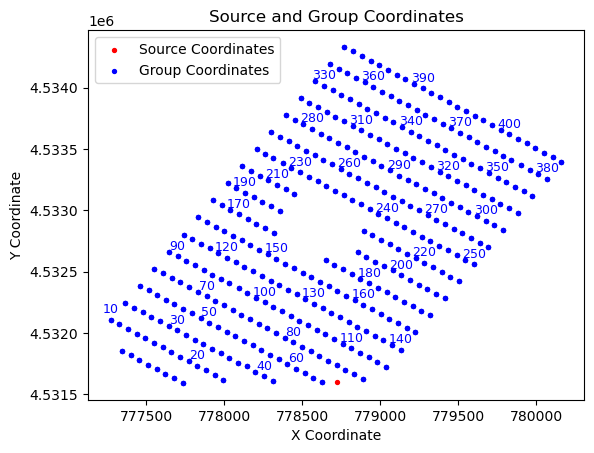

In [8]:
# Filter Out (0, 0) Pairs (User Option)
# Using a condition to exclude rows where both columns have 0 values
filtered_group_coordinate = group_coordinate[(group_coordinate['group_coordinate_x'] != 0) | (group_coordinate['group_coordinate_y'] != 0)]
# Plotting source_coordinate points in red
plt.scatter(source_coordinate['source_coordinate_x'], source_coordinate['source_coordinate_y'], color='red', label='Source Coordinates', s=8)
# Plotting filtered_group_coordinate points in blue
plt.scatter(filtered_group_coordinate['group_coordinate_x'], filtered_group_coordinate['group_coordinate_y'], color='blue', label='Group Coordinates', s=8)
# Adding labels to filtered_group_coordinate points, every 10 points
y_offset = 30
for i, row in filtered_group_coordinate.iterrows():
    if (row['trace_id'] % 10 == 0) and (row['trace_id'] < 410):  # Every 10 points and for the points [2-406] (User Option)
        plt.text(row['group_coordinate_x'], row['group_coordinate_y']+ y_offset, str(int(row['trace_id'])), color='blue', fontsize=9, verticalalignment='bottom', horizontalalignment='center')
# Customizing the plot
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Source and Group Coordinates')
plt.legend()
# Display the plot
plt.show()

### Plotting source and trace locations on an interactive base map

Now, we are focusing on accurately mapping the locations of source points and trace data onto an interactive base map. This approach utilizes dynamic mapping technology to offer users a detailed and easily navigable view of data points within their geographical context. By integrating source and trace locations onto an interactive platform, users can effortlessly explore spatial relationships and patterns, significantly enhancing the analysis and interpretation of complex geospatial datasets.

#### Coordinate system transformation

This section performs coordinate system transformations. Therefore, you need to be aware of both your source and target coordinate systems. In this example, we specifically transform from NAD 1983 State Plane Nevada West coordinates (EPSG:32109) to WGS84 (World Geodetic System 1984) latitude and longitude (EPSG:4326). The transformation process utilizes EPSG codes: EPSG:32109 for NAD 1983 State Plane Nevada West as the source projection and EPSG:4326 for WGS84 as the target projection. Users should modify this section to suit the coordinate system requirements of their data.

In [9]:
# Using Transformer class of pyproj (User Option)
# UTM zone 11N - EPSG code 32611
# NAD 1983 State Plane Nevada West - EPSG code 32109
transformer = Transformer.from_proj(
    proj_from='epsg:32109',  # EPSG code for NAD 1983 State Plane Nevada West
    proj_to='epsg:4326',  # EPSG code for WGS84
    always_xy=True
)
# Function to convert input coordinate system to WGS84 using Transformer
def input_to_wgs84(easting, northing):
    lon, lat = transformer.transform(easting, northing)
    return pd.Series([lat, lon])
# Apply the conversion to the DataFrame
group_coordinate[['latitude', 'longitude']] = group_coordinate.apply(
    lambda row: input_to_wgs84(row['group_coordinate_x'], row['group_coordinate_y']), axis=1
)
# Using a condition to exclude rows where both columns have 0 values
filtered_group_coordinate = group_coordinate[(group_coordinate['group_coordinate_x'] != 0) | (group_coordinate['group_coordinate_y'] != 0)]
# 
source_coordinate[['latitude', 'longitude']] = source_coordinate.apply(
    lambda row: input_to_wgs84(row['source_coordinate_x'], row['source_coordinate_y']), axis=1
)

#### Plotting on interactive base map

This code snippet is designed to visualize geographical data points on an interactive map using the Folium library, a powerful tool for creating maps in Python. The objective is to plot the locations of a single source and multiple group coordinates, ensuring the map is centered appropriately for an optimal view. The map's center is determined by calculating the average latitude and longitude of the source coordinates, ensuring that the visualization is centered around the relevant area of interest.

In [10]:
# Create a map centered around the average of the coordinates to ensure it's centered properly
map_center = [source_coordinate['latitude'].mean(), source_coordinate['longitude'].mean()]
print('source center coordinate: ' + str(map_center))
# Define the folium map
m = folium.Map(location=map_center, zoom_start=10, width='90%', height='90%')
# Add marker for source (assuming there's only one source_coordinate for simplicity)
for _, row in source_coordinate[['latitude', 'longitude']].iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,  # Smaller radius for source point
        popup='Source',
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7
    ).add_to(m)
# Add a CircleMarker for each coordinate in filtered_group_coordinate
for _, row in filtered_group_coordinate[['latitude', 'longitude', 'trace_id']].iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,  # Adjust the size by changing the radius
        popup=str(int(row['trace_id'])),
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(m)
# Display the map
m

source center coordinate: [39.540219663578995, -118.83084937450037]


## Plotting raw seismic data

### Plotting individual traces (User Option)

In this example, we demonstrate how to plot multiple seismic traces within a single figure for comparative analysis. We begin by plotting from trace 10 and include 5 traces in total. Users have the flexibility to specify their starting trace and the number of traces they wish to plot. This method is particularly useful for assessing variations and identifying patterns across the traces.

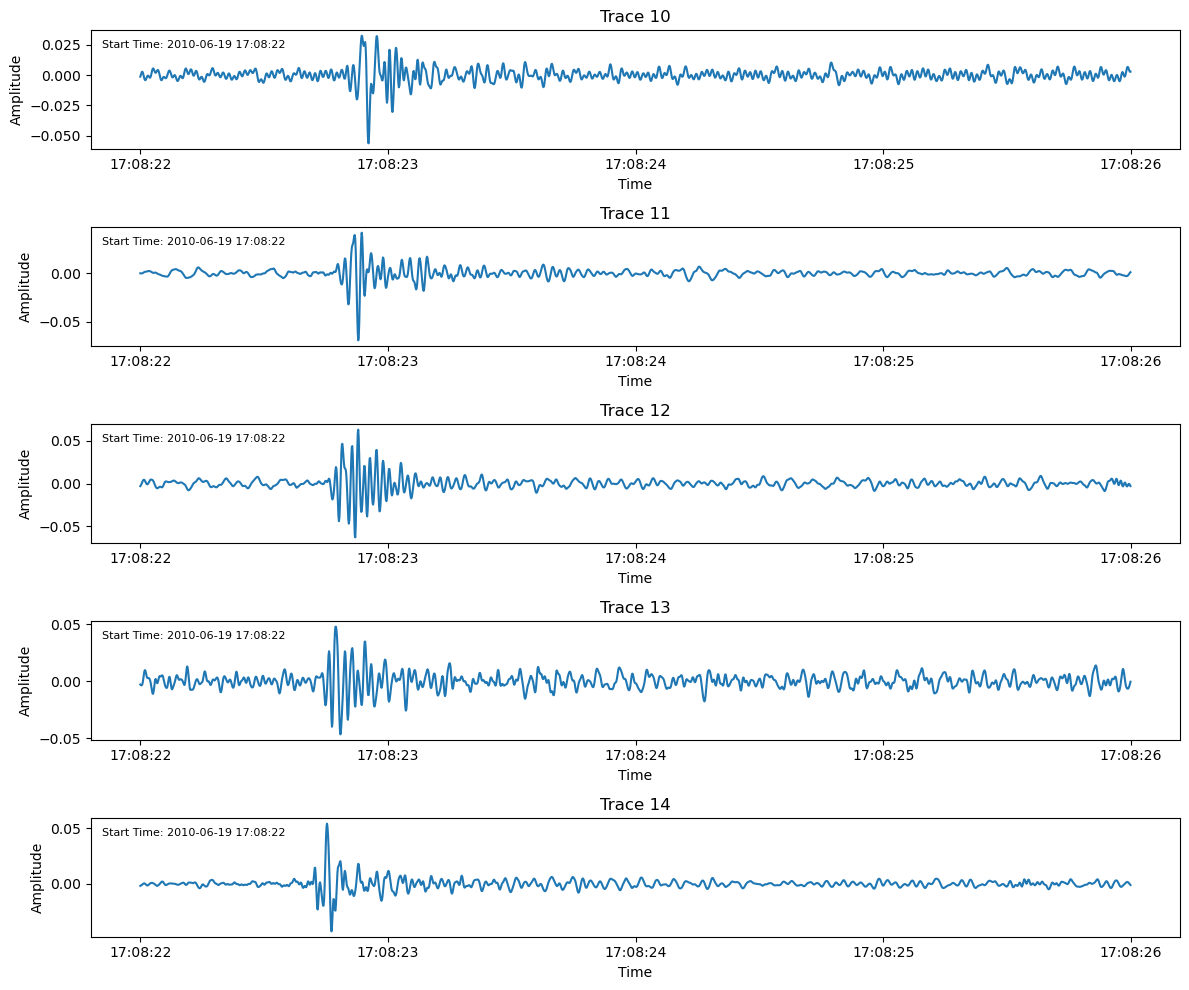

In [11]:
# Plot multi traces in one figure
# Determine the traces to plot (User Option)
start_number = 10
num_traces_to_plot = 5
traces_to_plot = data.traces[start_number:(start_number+num_traces_to_plot)]
# Sampling rate: we need to get it from the trace stats and convert to second
sampling_rate = 1/trace.stats.sampling_rate
# Create a figure to hold the subplots
plt.figure(figsize=(12, 10))
# Loop through the selected traces and plot each
for index, trace in enumerate(traces_to_plot, start=1):
    # Generate time vector based on sampling rate and number of samples
    times = pd.date_range(start=trace.stats.starttime.datetime, periods=len(trace.data), freq=pd.Timedelta(seconds=sampling_rate))
    # Create a subplot for each trace
    ax = plt.subplot(num_traces_to_plot, 1, index)
    ax.plot(times, trace.data)
    # Formatting the time axis to display date and time
    ax.xaxis_date()  # Interpret the x-axis values as dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Set the format for the dates

    plt.title(f'Trace {start_number + index - 1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    # Annotate the start time on the figure
    start_time_str = trace.stats.starttime.datetime.strftime('%Y-%m-%d %H:%M:%S')
    plt.annotate(f'Start Time: {start_time_str}', xy=(0.01, 0.85), xycoords='axes fraction', fontsize=8)
    # Optional: Add some spacing between plots for readability
    plt.tight_layout()
# Optional: Rotate date labels for better readability
# plt.gcf().autofmt_xdate()
# Show the plot
plt.show()

### Plotting all traces as an Image

Plotting all seismic traces as a single image helps us see the big picture of what's happening underground. It makes it easy to spot any unusual patterns or important features in the data right away. This method turns complicated data into something much simpler to understand, which is really helpful for quickly figuring out what the data is telling us about the earth's structure. By looking at all the traces together as one image, scientists can better understand how everything is connected below the surface.

First, we'll arrange the trace data into a 2D NumPy array, effectively stacking them for analysis.

In [12]:
# Extract the trace data and stack them side by side to form a 2D array
traces_data = np.stack([trace.data for trace in data.traces], axis=1)

#### Fundamental Dataset Statistics

Next, let's proceed to compute some fundamental statistics for our dataset.

In [13]:
# Calculate statistics
max_value = np.max(traces_data)
min_value = np.min(traces_data)
mean_value = np.mean(traces_data)
std_dev = np.std(traces_data)
# Print statistics
stats_message = f"The data has a maximum value of {max_value}, a minimum value of {min_value}, a mean value of {mean_value}, and a standard deviation of {std_dev}."
print(stats_message)

The data has a maximum value of 918.698974609375, a minimum value of -315.42236328125, a mean value of 1.5491441445192322e-06, and a standard deviation of 1.1680067777633667.


This distribution showcases significant extremes in the maximum and minimum values, contrasted by a relatively small standard deviation. To gain a better understanding of the spread and mitigate the influence of outliers, it is insightful to examine the trace identification codes.

In [14]:
# Initialize a dictionary to hold the trace_identification_codes
trace_id_codes = {}
# Loop over each trace in the data
for trace in data:
    # Extract the trace_identification_code from the trace header
    trace_id_code = trace.stats.segy.trace_header.trace_identification_code

    # Add the trace_id_code to the dictionary
    # The keys are the trace identification codes and the values are lists of trace indices
    if trace_id_code not in trace_id_codes:
        trace_id_codes[trace_id_code] = []
    trace_id_codes[trace_id_code].append(trace.stats.segy.trace_header.trace_sequence_number_within_segy_file)  # Assume each trace has a unique ID

# Now, trace_id_codes dictionary contains all the identification codes and their associated traces
# To find traces with different trace_identification_code, we simply look for dictionary keys with more than one trace
different_trace_codes = {code: traces for code, traces in trace_id_codes.items() if len(traces) > 1}

# Print out the results
print("Unique Trace Identification Codes and their corresponding trace indices:")
for code, traces in trace_id_codes.items():
    if len(traces) <= 10:
        # If there are 10 or fewer traces, it's reasonable to list them all
        trace_summary = ', '.join(map(str, traces))
    else:
        # For longer sequences, summarize with the first and last trace indices
        trace_summary = f"{traces[0]}-{traces[-1]} (Total: {len(traces)})"
    
    print(f"Code {code}: Traces {trace_summary}")

Unique Trace Identification Codes and their corresponding trace indices:
Code 8: Traces 1
Code 1: Traces 2-1216 (Total: 1215)


This result indicates that Trace 1 possesses a unique Trace Identification Code. We attempt to exclude it from the stacked data and subsequently analyze the data statistics.

In [15]:
# Remove the first trace data from the 2D array (User Option)
traces_data_cleaned = traces_data[:, 1:]
# Calculate statistics
max_value = np.max(traces_data_cleaned)
min_value = np.min(traces_data_cleaned)
mean_value = np.mean(traces_data_cleaned)
std_dev = np.std(traces_data_cleaned)
# Print statistics
stats_message = f"The data has a maximum value of {max_value}, a minimum value of {min_value}, a mean value of {mean_value}, and a standard deviation of {std_dev}."
print(stats_message)

The data has a maximum value of 19.873687744140625, a minimum value of -19.0426025390625, a mean value of 1.8605061313792248e-06, and a standard deviation of 0.15448807179927826.


It is insightful to examine the 1st and 99th percentiles of the dataset and use these values to adjust the color clipping for plotting.

In [16]:
# Calculate the 1st and 99th percentiles
percentile_1 = np.percentile(traces_data_cleaned, 1)
percentile_99 = np.percentile(traces_data_cleaned, 99)
# Print the percentiles
print(f"The 1st percentile of the data is {percentile_1}.")
print(f"The 99th percentile of the data is {percentile_99}.")

The 1st percentile of the data is -0.14426667392253875.
The 99th percentile of the data is 0.14383785068988442.


#### Showing all traces as an image using imshow

In this section, we set up a visualization to display all seismic traces collectively as a single image, offering a comprehensive overview of the entire seismic section. We apply a color map to differentiate data values effectively and use the 1st and 99th percentiles to scale our color range, focusing on the most relevant data features. This method highlights variations and patterns across traces, providing a clear, insightful view into the seismic dataset's structure and characteristics.

For seismic data visualization, the choice of colormap can significantly affect the interpretability of the data. As an example we introduced two colormaps that are often recommended for seismic data visualization:   
"Greys": This grayscale colormap is highly effective. It offers a clear, unambiguous representation of data, focusing on structural features over polarity.  
"seismic": Tailored for seismic data, this colormap typically assigns blue to negative values, white to values around zero, and red to positive values, making it intuitively interpretable in many seismic scenarios.  
Below is an example demonstrating how to visualize all trace data using the "Greys" colormap:

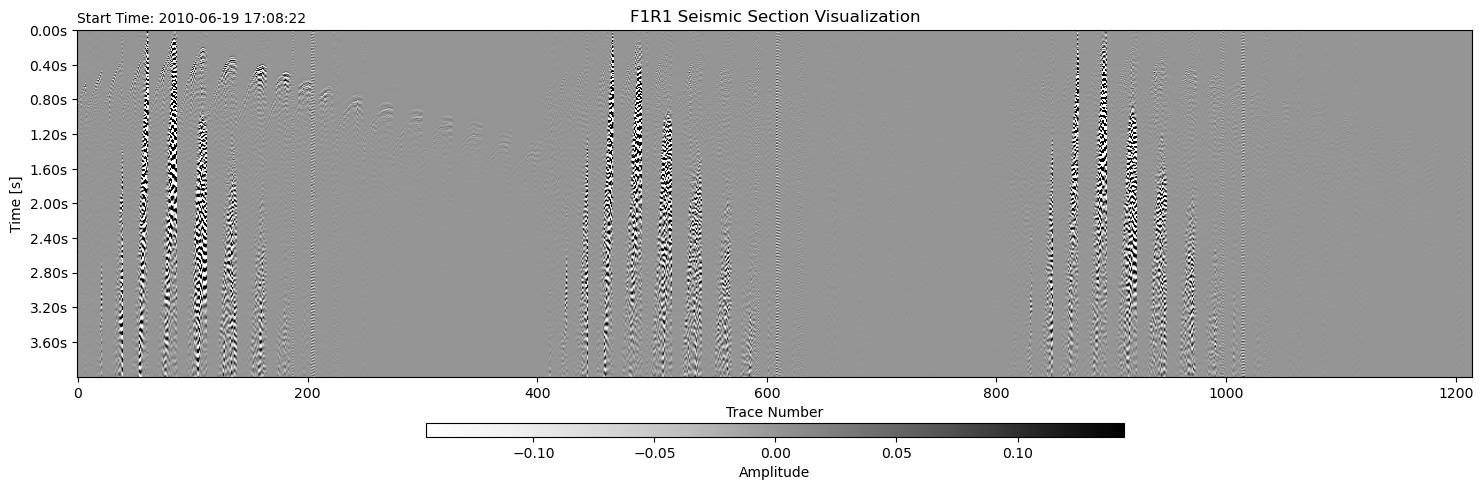

In [17]:
# Create subplots
(fig, ax) = plt.subplots(1, figsize=(18, 6))
# Plotting all traces as an image
# camp defines the color map, for example, "seismic", "Greys" (User Option)
seismic_section = ax.imshow(traces_data_cleaned, cmap="Greys", vmin=percentile_1, vmax=percentile_99, aspect='auto')
# Create a horizontal color bar at the bottom of the plot
cbar = plt.colorbar(seismic_section, ax=ax, orientation='horizontal', pad=0.1, aspect=50, shrink=0.5)
cbar.set_label('Amplitude')
# Set the title and axis labels
ax.set_title(name + ' Seismic Section Visualization')
ax.set_xlabel('Trace Number')
ax.set_ylabel('Time [s]')
# Calculate the time for each y index and set these as y-axis labels
num_rows = traces_data_cleaned.shape[0]
y_labels = np.arange(0, num_rows * sampling_rate, sampling_rate)  # Time labels
# Only display a reasonable number of labels to avoid clutter
step = max(len(y_labels) // 10, 1)  # Ensure at least 1 step to avoid division by zero
ax.set_yticks(np.arange(0, num_rows, step))
ax.set_yticklabels(["{:.2f}s".format(time) for time in y_labels[::step]])
# Annotate the start time on the figure
start_time_str = trace.stats.starttime.datetime.strftime('%Y-%m-%d %H:%M:%S')
plt.annotate(f'Start Time: {start_time_str}', xy=(0.00, 1.02), xycoords='axes fraction', fontsize=10)
# Display the plot
plt.show()

We also offer users the option to select specific traces for visualization. In this example, we demonstrate traces ranging from 0 to 600. Below, you will find an example showcasing the selected traces using the 'seismic' colormap.

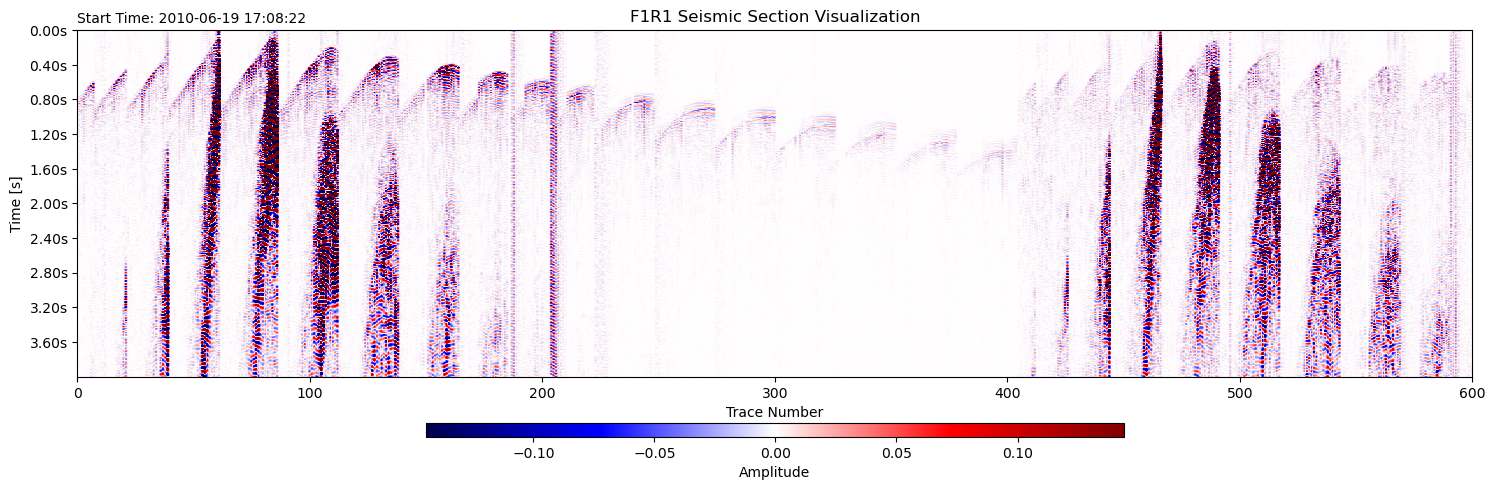

In [18]:
# Zoom in to see traces from i to j
(fig, ax) = plt.subplots(1, figsize=(18, 6))
# Define the trace number. This example demonstrates a range from 0 to 600 (User Option)
plt.xlim(0,600)
# Plotting all traces as an image
# camp defines the color map, for example, "seismic", "Greys" (User Option)
seismic_section = ax.imshow(traces_data_cleaned, cmap="seismic", vmin=percentile_1, vmax=percentile_99, aspect='auto')
# Create a horizontal color bar at the bottom of the plot
cbar = plt.colorbar(seismic_section, ax=ax, orientation='horizontal', pad=0.1, aspect=50, shrink=0.5)
cbar.set_label('Amplitude')
# Set the title and axis labels
ax.set_title(name + ' Seismic Section Visualization')
ax.set_xlabel('Trace Number')
ax.set_ylabel('Time [s]')
# Calculate the time for each y index and set these as y-axis labels
num_rows = traces_data_cleaned.shape[0]
y_labels = np.arange(0, num_rows * sampling_rate, sampling_rate)  # Time labels
# Only display a reasonable number of labels to avoid clutter
step = max(len(y_labels) // 10, 1)  # Ensure at least 1 step to avoid division by zero
ax.set_yticks(np.arange(0, num_rows, step))
ax.set_yticklabels(["{:.2f}s".format(time) for time in y_labels[::step]])
# Annotate the start time on the figure
start_time_str = trace.stats.starttime.datetime.strftime('%Y-%m-%d %H:%M:%S')
plt.annotate(f'Start Time: {start_time_str}', xy=(0.00, 1.02), xycoords='axes fraction', fontsize=10)
# Display the plot
plt.show()